## 1. Momentum


* Keeping track of gradients of previous rounds
* Speeds up traing, huge performace gains, almost no work. 0.9 is usually fine
* Similar to physical momentum - moves you in the direction you were already going
* Two flavors:
    * Regular momentum
    * Nesterov Momentum


### Regular Momentum

* Intuitively, the "velocity" is the previous weight change:

$$v(t-1) = \Delta w(t-1) $$

* Then we can update the weight as follow:

$$ \Delta w(t) = \mu v(t-1) - \eta \nabla J(t) $$

* Combine the above two formula, we get momentum update formula:

<b style="color:red"> $$ \Delta w(t) = \mu \Delta w(t-1) - \eta \nabla J(t) $$ </b>

where $\mu$ is the momentum parameter and $\eta$ is the learning rate

* Then, the formula of updating weight at time $t$ would be:

<b style="color:red"> $$ w = w + \Delta w(t) $$ </b>

** In code form:**

```python
# using gradient descent
dw = 0 # initially

v = dw
dw = momentum * v - learning_rate * gradient
w += dw
```

```python
# using gradient ascent (need to verify)
dw = 0 # initially

v = dw
dw = momentum * v + learning_rate * gradient
w += dw
```

### Nesterov Momentum

* Basic idea: look ahead, then correct yourself if you made a mistake
* Kinematics analogy



## 2. Variable Learning Rate

* learning rate is a function of time e.g., $\eta (t)$
* sometimes, called "learning rate scheduling"

### Step decay

* Periodically reduce the learning rate by a constant factor 
 * Reduce every 5, 10, or 20 steps
 
<img src="images/step_decay_pic.png" alt="step_decay_pic" height="40%" width="40%"/>


```
Ex.

if iter % 10 == 0:
    learning_rate /= 2
```

### Exponential decay

* The learning rate follows an exponential curve:

$$ \eta (t) = A * exp(-kt) $$ 

<img src="images/ex_decay_pic.png" alt="ex_decay_pic" height="60%" width="60%"/>


### 1/t decay

* The learning rate decays proportionally to 1/t
* Dropoff is slower than exponential decay
* You can control the decay rate by changing the proportionality constant

   $$ \eta (t) = \eta (0) / (1 + kt) $$
   
<img src="images/one_over_t_pic.png" alt="one_over_t_pic" height="60%" width="60%"/>


### Take-away

* The above methods have commons:
    * Learning rate decreases with time
        * Why we want this? 
> Initially, weights are far from optimal, we want start with a large learning rate so that we can take bigger steps towards the goal (this is the motivation behind momentum as well). However, as we get closer to the minimum, we want to slow down the learning rate to avoid overshooting in which case we may end up bouncing back and forth, or even bouncing out of the minimal valley.

* All these methods add more hyperparameters to be optimized
* Even choosing between these methods is a hyperparameter choice
* Therefore, these techniques may be helpful. But, they also increase your work load

### Babysitting method

* Do a few epochs, see how it goes by examing the cost/loss graph
* If the learning is too slow, we may increase the learning rate. If learning is starting to even out, we may decrease the learning rate
* We should be careful about the plateau (a relatively flat portion of the surface), which may cause us temporiarily get stuck since nice monotonically decreasing curve is not guaranteed. But, we may end up getting a steep drop is we are patient enough (again, not guaranteed)


## 3. Adaptive Learning Rate

* AdaGrad, 
* RMSprop, 




### AdaGrad (Adaptive Gradient)

* <b style="color:red">Dependence of cost on each parameter is not the same</b>. Steep gradient in one direction, but flat in another
* Adapt the learning rate for each parameter individually, based on how much "learning" it has done so far
    * If the learning is too fast, it will slow down the learning.
    * It is good for learning at later stage when we usually need slower learning rate.
* adaptive method (based on weights changes so far)

$$ cache = cache + gradient^2 $$

$$  w  \leftarrow w - \eta {\nabla J \over \sqrt{cache + \epsilon}} $$

Typically, $ \epsilon $  is a small number, i.e. around 1E-8 or 1E-10, so we do not divide by 0

* The cache is accumulating the squared gradients and it is updated at every batch assuming we are using batch gradient descent
* Note, in AdaGrad, everything is element-wise. Each scalar parameter and its learning rate is updated independently of the others

> Because each parameter has its own cache, if one parameter has had a lot of large gradients in the past, then its cache will be very large and its effective learning rate will be very small. Also, it will change more slowly in the future. On the other hand, if a parameter has had a lot of small gradient in the past, then its cache will be small and its effective learning rate will be large and thus it will have more opportunity to change in the future


### RMSprop (Root Mean Sqare Propagation)

* An variation of AdaGrad. 
> It is motivated by the fact that AdaGrad decreases learning rate too aggressively so that the learning rate would approach zero too quickly when in fact there was still more learning to be done
* The reason RMSprop decreases the learning rate too quickly is because the cache is growing too fast. In order to make the cache grows less fast, we decrease it each time we update it. We do it by computing <b style="color:red">on-the-fly (online) moving average</b> of the old cache and the new squared gradient:

$$ cache = decay * cache + (1 - decay) * gradient^2 $$

where decay is a hyper-parameter that controls the how much weight is given in this average to older vs most recent $gradient^2$. Typically values for the decay is: 0.99, 0.999, etc.

> Note, this formula is actually <b style="color:red">exponentially-smoothed average</b> of the squared gradient. The "cache" is really estimating the mean of the the squared gradient: $ mean(gradient^2) $

> Because we eventually use the square root of the cache, now we can see where RMSprop gets its name from (RMS = "root mean square")
 
* We say the cache is "leaky", because:

> If we had zero gradients for a long time, eventually the cache would shrink back down to zero since it would be decreased by the decay rate on each round 

* Then, we update the parameter

$$  w  \leftarrow w - \eta {\nabla J \over \sqrt{cache + \epsilon}} $$

Typically, epsilon is a small number, i.e. $10^{-10}$, so we do not divide by 0

* The <b style="color:red">effective learning</b> rate of the above formula is:

$$ {\eta  \over \sqrt{cache + \epsilon}} $$


** One ambiguity problem of RMSProp**

What is the initial value of cache?

Let's assume the initical value of cache is 0 and decay is 0.999, then we have the initial updated cache:

$$ 0.001 g^2 $$

Then initial update (ignoring epsilon):

$$ {\eta \over \sqrt{0.001 g^2}}g $$

The effective learning rate actually becomes very large due to the fact that the denominator is very small. What we have to do is to compensate by making the initial learning rate smaller than usual.

One solution: initialize <b style="color:red">cache = 1</b>. Then, the effective learning rate is approximately equal to the initial learning rate divide by one:

$$ \Delta w = {\eta \over \sqrt{1 + 0.001 g^2}}g \approx \eta g $$

So, which initial value for cache (0 or 1) is correct? Major packages have implemented both:
    * Tensorflow initializes cache = 1
    * Keras initializes cache = 0

### Pseudocode

**AdaGrad**

```python
# for each batch:
cache = cache + gradient**2
param = param - learning_rate * gradient / sqrt(cache + epsilon)
```

**RMSProp**

```python
# for each batch:
cache = decay * cache + (1 - decay) * gradient**2
param = param - learning_rate * gradient / sqrt(cache + epsilon)
```
epsilon = $ 10^{-8}, 10^{-9}, 10^{-10} $, etc ..., 
decay = 0.9, 0.99, 0.999, 0.9999. etc ...

## 4. Adam Optimizer

* Adam optimizer deserves its own section since it is often considered the go-to default these day

$$ v_t = decay * v_{t-1} + (1 - decay) * g^2_t \approx mean(g^2) $$

The mean of random variable is its expected value, e.g., mean(X) = E(X)
* In particular, when we take the expected value of the square of a random variable, we call this the second moment: 
$$ E(X^2) =  \text{2nd (raw) moment of X} $$
* In general, the expected value of X to the n is the nth moment of X: 
$$ E(X^n) = \text{nth (raw) moment of X} $$

Then we know that:
$$ v \approx E(g^2) $$

is the second moment of the gradient and calculate it using the exponentially-smoothed average.

Similarly, we compute exponentially-smoothed average of $g$, which is the first moment of $g$:

$$ m_t = decay * m_{t-1} + (1 - decay) * g_t \approx mean(g) $$

Then we know that:
$$ m \approx E(g) $$

* "m" stands for "mean"
* Adam makes use of the 1st and 2nd moments of g, which explains what "Adam" stands for: <b style="color:red">"Adaptive Moment Estimation"</b>
* Adam is a combination of these 2 things: m and v

**Same issue as with RMSProp** - what is the initial value of the output of the exponentially-smoothed average? The output is supposed to depend on the last value of the output plus current value of the input. Since there is no last value of the output for the $t=0$, we typically set the output value at $t=0$ to zero. But, buy doing so, we then set the initial value of the output to something like 0.01 times the first input:

$$ Y(0) = 0 $$
$$ Y(1) = 0.99 * Y(0) + 0.01 * X(1) = 0.01 * X(1) $$

assuming decay rate is 0.99
Therefore, initially, the output is goint to be biased towards zero. To correct this bias, we do bias correction:

$$  \hat{Y}(t) = {Y(t) \over {1 - decay^t}} $$

Continue to calculate $Y(t)$ as normal

When $t$ is small, we are dividing $Y(t)$ by a very small number that makes the initial value bigger. This make senses because the initial value was too small.

Example:

Given decay = 0.99

$$ Y(1) = 0.01 * X(1) $$

$$ Y(2) = 0.01 * 0.99 * X(1) + 0.01 * X(2) $$

corrected:

$$  \hat{Y}(1) = {0.01 \over {1 - 0.99^1}}X(1) = X(1)$$

$$  \hat{Y}(2) = {{0.0099*X(1) + 0.01*X(2)} \over {1 - 0.99^2}} = 0.496*X(1) + 0.503*X(2) $$

When $t$ approaches infinity, the bias correction approaches 1, so we quickly converge to the standard exponentially smooth average. The important part is that our output now has the correct range of values when compared with the input for all values of the input including the initial ones.

**Back to Adam**

We perform correction on both $m$ and $v$:

$$  \hat{m}_t = {m_t \over {1 - \beta^t_1}} $$

$$  \hat{v}_t = {v_t \over {1 - \beta^t_2}} $$

Then, we have:

$$  w_{t+1}  \leftarrow w_t - \eta {\hat{m}_t  \over \sqrt{\hat{v}_t  + \epsilon}} $$

Typicall values for decay rate $\beta$: $0.9 ... 0.999$ range, while $\epsilon$: $10^{-8} ... 10^{-10}$ range


**Recap**
* Adam is a modern adaptive learning rate technique that is default for many deep learning practitioners
* Combines RMSProp (cache mechanism) with momentum (keeping track of old gradients)
* Generalize as first and second moments
* Apply bias correction


**Pseudocode for Adam Optimizer**

$$ m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t $$


$$ v_t = \beta_2 v_{t-1} + (1 - \beta_2) g^2_t $$


$$  \hat{m}_t = {m_t \over {1 - \beta^t_1}} $$


$$  \hat{v}_t = {v_t \over {1 - \beta^t_2}} $$


$$  w_{t+1}  \leftarrow w_t - \eta {\hat{m}_t  \over \sqrt{\hat{v}_t  + \epsilon}} $$

## 5. Caveat

* May 2017 paper: "The Marginal Value of Adapive Gradient Method in Machine Learning"
 * Experimental results show regular gradient descent performs better than these adaptive techniques
* Stick to the fundamentals

## 6.  Practical Debugging Techniques

### Learning Rate 

* Choose learning rate in log scale of factor 10. $ 10^{-1}, 10^{-2}, 10^{-3},..., etc $
* How to determine whether learning rate is too high or too low
    * Cost goes to infinity/NaN --> learning rate is too high
        * Neural network will continue to train as normal, multiplying NaNs as if they were actual numbers
    * Cost converges too slowly --> learning rate is too low
        * Try increase learning rate by factor of 10
* A good debugging technique:
    * Try to turn off all modification except for regular gradient descent (no regularization, no momentum or anything else)
    * Learning rate that is too high will mess things up. But learning rate that is too low will not. It will just train more slowly.
    * If things still do not work, it could be a problem with your code.


### Normalizing cost and regularization penalty

* Learning rate will be sensitive to number of training points (i.e., batch size) because cost/loss is sum of individual errros. 
    * Divide cost/loss by batch size to normalize it
* To make regularization penalty independent of number of parameters. 
    * Divide penalty by number of parameters.
    
    
### Regularization too high

* If the regularization parameter $\lambda$ is too high (e.g., for some particular problem $\lambda$ of 1 is too high), the error rate may hover around random guessing.
* Sometimes, it is useful to turn off regularization completely and make learning rate very small. This may tell you whether the model actually works or whether there is a bug in code.

In [116]:
import os
import numpy as np
import pandas as pd

def get_normalized_data():

    print("Reading in and transforming data...")

    if not os.path.exists('../data/minst/train.csv'):
        print('Looking for ../data/minst/train.csv')
        print('You have not downloaded the data and/or not placed the files in the correct location.')
        print('Please get the data from: https://www.kaggle.com/c/digit-recognizer')
        print('Place train.csv in the folder large_files adjacent to the class folder')
        exit()

    df = pd.read_csv('../data/minst/train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)

    # X is a matrix of all the samples excluding the first column which is label column
    X = data[:, 1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std == 0, 1)
    X = (X - mu) / std # normalize the data
    Y = data[:, 0]
    return X, Y

X, Y = get_normalized_data()

print(X.shape)

Reading in and transforming data...
(42000, 784)


In [117]:
# softmax(sigmoid(X*W1 + b1)*W2 + b2)
def forward(X, W1, b1, W2, b2):
#     Z = sigmoid(X.dot(W1) + b1)
    Z = relu(X.dot(W1) + b1)
    Y = softmax(Z.dot(W2) + b2)  
    return Y, Z

def relu(A):
    A[A<0] = 0
    return A
    
def sigmoid(A):
    return 1 / (1 + np.exp(-A))

def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

def derivative_W2(T, Y, Z):
    return Z.T.dot(Y - T)

def derivative_b2(T, Y):
    return (Y - T).sum(axis=0)
    
def derivative_W1(T, Y, W2, Z, X):
#     dA = (Y - T).dot(W2.T) * Z * (1 - Z)
    dA = (Y - T).dot(W2.T) * (Z > 0)
    return X.T.dot(dA)

def derivative_b1(T, Y, W2, Z):
#     dz = (Y - T).dot(W2.T) * Z * (1 - Z)
    dz = (Y - T).dot(W2.T) * (Z > 0)
    return dz.sum(axis=0)

def y2indicator(y, k):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, k))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

def predict(p_y):
    return np.argmax(p_y, axis=1)

def error_rate(p_y, t):
    prediction = predict(p_y)
    return np.mean(prediction != t)

def cross_entropy(p_y, t):
    tot = t * np.log(p_y)
    return -tot.sum()

In [118]:
def GradientDescentOptimizer(Xbatch, Ybatch, pYbatch, Z, W1, b1, W2, b2, 
                             reg=0.01, learning_rate=0.001):

    # pYbatch, Ybatch, Z, 
    W2 -= learning_rate * (derivative_W2(Ybatch, pYbatch, Z) + reg * W2)
    b2 -= learning_rate * (derivative_b2(Ybatch, pYbatch) + reg * b2)
    W1 -= learning_rate * (derivative_W1(Ybatch, pYbatch, W2, Z, Xbatch) + reg * W1)
    b1 -= learning_rate * (derivative_b1(Ybatch, pYbatch, W2, Z) + reg * b1)

    return W1, b1, W2, b2

In [119]:
def RMSPropOptimizer(Xbatch, Ybatch, pYbatch, Z, W1, b1, W2, b2, 
                     cache_W1, cache_b1, cache_W2, cache_b2, reg=0.01, learning_rate=0.001):

    eps = 0.000001
    decay_rate = 0.999
    
    # calculate gradient descent
    gW2 = derivative_W2(Ybatch, pYbatch, Z) + reg * W2
    # update cache
    cache_W2 = decay_rate * cache_W2 + (1 - decay_rate) * gW2 * gW2
    # udpate weight
    W2 -= learning_rate * gW2 / (np.sqrt(cache_W2) + eps)

    gb2 = derivative_b2(Ybatch, pYbatch) + reg * b2
    cache_b2 = decay_rate * cache_b2 + (1 - decay_rate) * gb2 * gb2
    b2 -= learning_rate * gb2 / (np.sqrt(cache_b2) + eps)

    gW1 = derivative_W1(Ybatch, pYbatch, W2, Z, Xbatch) + reg * W1
    cache_W1 = decay_rate * cache_W1 + (1 - decay_rate) * gW1 * gW1
    W1 -= learning_rate * gW1 / (np.sqrt(cache_W1) + eps)

    gb1 = derivative_b1(Ybatch, pYbatch, W2, Z) + reg * b1
    cache_b1 = decay_rate * cache_b1 + (1 - decay_rate) * gb1 * gb1
    b1 -= learning_rate * gb1 / (np.sqrt(cache_b1) + eps)

    return W1, b1, W2, b2, cache_W1, cache_b1, cache_W2, cache_b2

In [120]:
def AdamOptimizer(Xbatch, Ybatch, pYbatch, Z, W1, b1, W2, b2, 
    mW1, vW1, mb1, vb1, mW2, vW2, mb2, vb2, t, reg=0.01, learning_rate=0.001):

    eps = 1e-8
    beta_m = 0.9
    beta_v = 0.999

    # gradients
    gW2 = derivative_W2(Ybatch, pYbatch, Z) + reg * W2
    gb2 = derivative_b2(Ybatch, pYbatch) + reg * b2
    gW1 = derivative_W1(Ybatch, pYbatch, W2, Z, Xbatch) + reg * W1
    gb1 = derivative_b1(Ybatch, pYbatch, W2, Z) + reg * b1

    # new m
    mW2 = beta_m * mW2 + (1 - beta_m) * gW2
    mb2 = beta_m * mb2 + (1 - beta_m) * gb2
    mW1 = beta_m * mW1 + (1 - beta_m) * gW1
    mb1 = beta_m * mb1 + (1 - beta_m) * gb1

    # new v
    vW2 = beta_v * vW2 + (1 - beta_v) * gW2 * gW2
    vb2 = beta_v * vb2 + (1 - beta_v) * gb2 * gb2
    vW1 = beta_v * vW1 + (1 - beta_v) * gW1 * gW1
    vb1 = beta_v * vb1 + (1 - beta_v) * gb1 * gb1

    # correction
    correction_m = 1 - beta_m ** t
    corr_mW2 = mW2 / correction_m
    corr_mb2 = mb2 / correction_m
    corr_mW1 = mW1 / correction_m
    corr_mb1 = mb1 / correction_m

    correction_v = 1 - beta_v ** t
    corr_vW2 = vW2 / correction_v
    corr_vb2 = vb2 / correction_v
    corr_vW1 = vW1 / correction_v
    corr_vb1 = vb1 / correction_v

    # apply updates to the params
    W2 -= learning_rate * corr_mW2 / np.sqrt(corr_vW2 + eps)
    b2 -= learning_rate * corr_mb2 / np.sqrt(corr_vb2 + eps)
    W1 -= learning_rate * corr_mW1 / np.sqrt(corr_vW1 + eps)
    b1 -= learning_rate * corr_mb1 / np.sqrt(corr_vb1 + eps)

    return W1, b1, W2, b2, mW1, vW1, mb1, vb1, mW2, vW2, mb2, vb2

In [132]:
def mlp_mnist_model(X, Y, opt='Gradient', learning_rate=0.001):

    max_iter = 20
    print_period = 40

    reg = 0.01

    Xtrain = X[:-1000,]
    Ytrain = Y[:-1000]

    Xtest = X[-1000:,]
    Ytest = Y[-1000:]

    # get number of classes
    K = len(set(Y))

    Ytrain_ind = y2indicator(Ytrain, K)
    Ytest_ind = y2indicator(Ytest, K)

    N, D = Xtrain.shape
    batch_size = 500
    n_batches = N / batch_size

    M = 300
    
    # here normalizing weights is important
    W1 = np.random.randn(D, M) / np.sqrt(D)
    b1 = np.zeros(M)
    W2 = np.random.randn(M, K) / np.sqrt(M)
    b2 = np.zeros(K)

    cache_W2 = 0
    cache_b2 = 0
    cache_W1 = 0
    cache_b1 = 0
    
    vW1 = 0
    vb1 = 0
    vW2 = 0
    vb2 = 0

    LL_batch = []
    CR_batch = []

    for itr in range(max_iter):
        t = 0
        for start_b in range(0, N, batch_size):
            t += 1
            end_b = start_b + batch_size

            Xbatch = Xtrain[start_b:end_b]
            Ybatch = Ytrain_ind[start_b:end_b]

            pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)

            if opt == 'Gradient':
                W1, b1, W2, b2 = GradientDescentOptimizer(Xbatch, Ybatch, pYbatch, Z, 
                                                          W1, b1, W2, b2, reg, learning_rate)
            elif opt == 'RMSprop':

                W1, b1, W2, b2, cache_W1, cache_b1, cache_W2, cache_b2 = RMSPropOptimizer(
                                                          Xbatch, Ybatch, pYbatch, Z, 
                                                          W1, b1, W2, b2, 
                                                          cache_W1, cache_b1, cache_W2, cache_b2,
                                                          reg, learning_rate)
            elif opt == 'Adam':
                W1, b1, W2, b2, cache_W1, vW1, cache_b1, vb1, cache_W2, vW2, cache_b2, vb2 = AdamOptimizer(Xbatch, Ybatch,
                                        pYbatch, Z, W1, b1, W2, b2,
                                        cache_W1, vW1, cache_b1, vb1, cache_W2, vW2, cache_b2, vb2, 
                                        t, reg, learning_rate)

            if t % print_period == 0:
                pY, _ = forward(Xtest, W1, b1, W2, b2)

                ll = cross_entropy(pY, Ytest_ind)
                LL_batch.append(ll)
                print("Cost at iteration itr=%d, j=%d: %.6f" % (itr, t, ll))

                err = error_rate(pY, Ytest)
                CR_batch.append(err)
                print("Error, rate:", err)

    pY, _ = forward(Xtest, W1, b1, W2, b2)
    print("Final error rate:", error_rate(pY, Ytest))
    return LL_batch

In [134]:
# learning_rate = 0.00004
costs_G = mlp_mnist_model(X ,Y, 'Gradient', learning_rate=0.0001)

Cost at iteration itr=0, j=40: 659.296555
Error, rate: 0.161
Cost at iteration itr=0, j=80: 462.043248
Error, rate: 0.112
Cost at iteration itr=1, j=40: 387.758834
Error, rate: 0.1
Cost at iteration itr=1, j=80: 346.104513
Error, rate: 0.083
Cost at iteration itr=2, j=40: 321.032675
Error, rate: 0.08
Cost at iteration itr=2, j=80: 301.379749
Error, rate: 0.073
Cost at iteration itr=3, j=40: 288.492719
Error, rate: 0.073
Cost at iteration itr=3, j=80: 276.459048
Error, rate: 0.068
Cost at iteration itr=4, j=40: 267.806303
Error, rate: 0.067
Cost at iteration itr=4, j=80: 259.774197
Error, rate: 0.068
Cost at iteration itr=5, j=40: 253.102836
Error, rate: 0.065
Cost at iteration itr=5, j=80: 247.073147
Error, rate: 0.065
Cost at iteration itr=6, j=40: 241.697600
Error, rate: 0.064
Cost at iteration itr=6, j=80: 237.036072
Error, rate: 0.063
Cost at iteration itr=7, j=40: 232.491991
Error, rate: 0.062
Cost at iteration itr=7, j=80: 228.673100
Error, rate: 0.061
Cost at iteration itr=8, j=

In [135]:
costs_A = mlp_mnist_model(X ,Y, 'Adam', learning_rate=0.001)

Cost at iteration itr=0, j=40: 294.643615
Error, rate: 0.075
Cost at iteration itr=0, j=80: 219.278834
Error, rate: 0.063
Cost at iteration itr=1, j=40: 200.270563
Error, rate: 0.052
Cost at iteration itr=1, j=80: 183.264379
Error, rate: 0.051
Cost at iteration itr=2, j=40: 175.592798
Error, rate: 0.046
Cost at iteration itr=2, j=80: 168.311616
Error, rate: 0.046
Cost at iteration itr=3, j=40: 164.357579
Error, rate: 0.041
Cost at iteration itr=3, j=80: 158.878251
Error, rate: 0.041
Cost at iteration itr=4, j=40: 156.851223
Error, rate: 0.04
Cost at iteration itr=4, j=80: 151.942987
Error, rate: 0.041
Cost at iteration itr=5, j=40: 151.314832
Error, rate: 0.039
Cost at iteration itr=5, j=80: 147.068813
Error, rate: 0.038
Cost at iteration itr=6, j=40: 146.977741
Error, rate: 0.038
Cost at iteration itr=6, j=80: 143.627292
Error, rate: 0.039
Cost at iteration itr=7, j=40: 144.081424
Error, rate: 0.037
Cost at iteration itr=7, j=80: 140.976081
Error, rate: 0.037
Cost at iteration itr=8, 

In [136]:
costs_R = mlp_mnist_model(X ,Y, 'RMSprop', learning_rate=0.001)

Cost at iteration itr=0, j=40: 305.151067
Error, rate: 0.065
Cost at iteration itr=0, j=80: 203.843230
Error, rate: 0.055
Cost at iteration itr=1, j=40: 176.585413
Error, rate: 0.044
Cost at iteration itr=1, j=80: 171.853048
Error, rate: 0.044
Cost at iteration itr=2, j=40: 155.038483
Error, rate: 0.041
Cost at iteration itr=2, j=80: 158.899569
Error, rate: 0.041
Cost at iteration itr=3, j=40: 146.765610
Error, rate: 0.037
Cost at iteration itr=3, j=80: 150.551619
Error, rate: 0.04
Cost at iteration itr=4, j=40: 143.089637
Error, rate: 0.035
Cost at iteration itr=4, j=80: 144.598539
Error, rate: 0.039
Cost at iteration itr=5, j=40: 140.983015
Error, rate: 0.035
Cost at iteration itr=5, j=80: 141.820930
Error, rate: 0.038
Cost at iteration itr=6, j=40: 140.490388
Error, rate: 0.035
Cost at iteration itr=6, j=80: 139.790070
Error, rate: 0.036
Cost at iteration itr=7, j=40: 140.464524
Error, rate: 0.036
Cost at iteration itr=7, j=80: 139.480166
Error, rate: 0.038
Cost at iteration itr=8, 

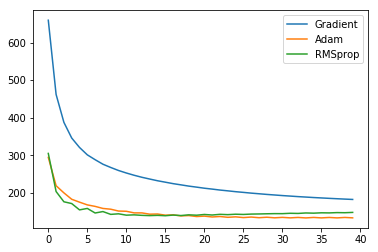

In [137]:
import matplotlib.pyplot as plt

plt.plot(costs_G, label='Gradient')
plt.plot(costs_A, label='Adam')
plt.plot(costs_R, label='RMSprop')
plt.legend()
plt.show()